### This file contains Functions to Preprocess the data, create features and make clusters in data set

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def process_fleet_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes raw fleet data to calculate trip-level features.

    This function performs the following steps:
    1. Converts the 'speed', 'timeStamp', and 'rpm' columns to the correct data types.
    2. Sorts the data by 'deviceID' and 'timeStamp'.
    3. Calculates acceleration for each device based on speed and time differences.
    4. Aggregates the data by 'deviceID' and 'tripID' to calculate statistical
       features (mean, max, std) for various metrics.
    5. Flattens the MultiIndex columns created during aggregation.
    6. Scales a selected set of features using StandardScaler.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing raw fleet data.
                          It must contain the columns: 'deviceID', 'tripID',
                          'timeStamp', 'speed', 'rpm', 'kpl'.

    Returns:
        pd.DataFrame: A new DataFrame with the aggregated and scaled features.
                      The returned DataFrame will have columns like 'deviceID',
                      'tripID', 'speed_mean', 'rpm_mean', etc.
    """
    # Create a copy to avoid modifying the original DataFrame
    df_combined = df.copy()

    # Convert columns to the correct data types
    df_combined['timeStamp'] = pd.to_datetime(df_combined['timeStamp'], errors='coerce')
    df_combined['speed'] = pd.to_numeric(df_combined['speed'], errors='coerce')
    df_combined['rpm'] = pd.to_numeric(df_combined['rpm'], errors='coerce')

    # Sort the data by device and timestamp for correct time-series calculations
    df_combined = df_combined.sort_values(['deviceID', 'timeStamp'])

    # Calculate acceleration (speed difference / time difference in seconds)
    df_combined['time_diff'] = df_combined.groupby('deviceID')['timeStamp'].diff().dt.total_seconds()
    df_combined['speed_diff'] = df_combined.groupby('deviceID')['speed'].diff()
    df_combined['acceleration'] = df_combined['speed_diff'] / df_combined['time_diff']

    # Fill initial NaNs that result from the `diff()` operation with 0
    df_combined['acceleration'] = df_combined['acceleration'].fillna(0)

    # Aggregate data by 'deviceID' and 'tripID' to create trip-level features
    df_agg = df_combined.groupby(['deviceID', 'tripID']).agg({
        'speed': ['mean', 'max', 'std'],
        'rpm': ['mean', 'max', 'std'],
        'acceleration': ['mean', 'max', 'std'],
        'kpl': ['mean', 'min'],
    })

    # Flatten the MultiIndex columns for easier access and cleaner output
    df_agg.columns = ['_'.join(col) for col in df_agg.columns]
    df_agg = df_agg.reset_index()

    # Scale selected features using StandardScaler
    scaler = StandardScaler()
    features_to_scale = ['speed_mean', 'rpm_mean', 'acceleration_mean']
    
    # Check if the columns exist before scaling to prevent errors
    if all(col in df_agg.columns for col in features_to_scale):
        df_agg[features_to_scale] = scaler.fit_transform(df_agg[features_to_scale])
    else:
        print("Warning: Some features to scale were not found in the aggregated data.")

    return df_agg

def find_optimal_k(X: np.ndarray, Z: np.ndarray, ks: range = range(2, 9)) -> int:
    """
    Finds the optimal number of clusters (k) using the Silhouette Score.

    Args:
        X (np.ndarray): The feature data used for clustering.
        Z (np.ndarray): The linkage matrix from hierarchical clustering.
        ks (range): The range of k values to evaluate.

    Returns:
        int: The optimal number of clusters.
    """
    scores = []
    # Loop through the desired number of clusters
    for k in ks:
        # Get cluster labels for the current k
        labels = fcluster(Z, t=k, criterion='maxclust')
        # Calculate the Silhouette Score, which measures how well-defined the clusters are
        scores.append(silhouette_score(X, labels))
    
    # Find the k that corresponds to the highest score
    best_k = ks[np.argmax(scores)]
    print(f"Silhouette scores for k in {list(ks)}: {scores}")
    print(f"Optimal number of clusters (best_k): {best_k}")
    
    return best_k

def perform_hierarchical_clustering_analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs a complete hierarchical clustering analysis, including finding the
    optimal number of clusters, generating a dendrogram and pairplot, and
    adding cluster labels to the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame. It must contain the columns
                           'speed_mean', 'rpm_mean', and 'acceleration_mean'.

    Returns:
        pd.DataFrame: A new DataFrame with the same data plus a 'cluster' column.
    """
    # Create a copy to avoid modifying the original DataFrame
    df_clustered = df.copy()

    # Define the features to be used for clustering
    features = ['speed_mean', 'rpm_mean', 'acceleration_mean']

    # Ensure the required features are present in the DataFrame
    if not all(feature in df_clustered.columns for feature in features):
        raise ValueError(f"Input DataFrame must contain all of the following columns: {features}")

    # Extract the features as a NumPy array for clustering
    X = df_clustered[features].values

    # Perform hierarchical clustering using the 'ward' method
    Z = linkage(X, method='ward')

    # Find the optimal number of clusters (k) using the Silhouette Score
    optimal_k = find_optimal_k(X, Z)

    # Form clusters based on the desired number of clusters (k)
    clusters = fcluster(Z, optimal_k, criterion='maxclust')
    df_clustered['cluster'] = clusters

    # Calculate the distance threshold for the dendrogram based on k
    distance_cut = Z[-(optimal_k - 1), 2] if optimal_k > 1 else 0

    # Generate and plot the hierarchical clustering dendrogram
    plt.figure(figsize=(10, 6))
    plt.title(f'Hierarchical Clustering Dendrogram for {optimal_k} Clusters (truncated)')
    plt.xlabel('Cluster size (if truncated)')
    plt.ylabel('Distance')
    dendrogram(
        Z,
        truncate_mode='lastp',  # condense the tree
        p=optimal_k * 2,                # show more than the final number of clusters for context
        orientation='right',    # horizontal tree for readability
        show_leaf_counts=True,  # show counts for truncated leaves
        color_threshold=distance_cut,
        leaf_rotation=0,
        leaf_font_size=10,
        show_contracted=True    # show dots for hidden merges
    )

    # Draw the cut line to visualize the chosen number of clusters
    plt.axhline(y=distance_cut, color='grey', lw=1, ls='--')
    plt.tight_layout()
    plt.show()

    # Generate a pairplot to visualize the clusters
    sns.set_style("whitegrid")
    sns.pairplot(df_clustered, hue='cluster', vars=features)
    plt.suptitle(f'Pairplot with {optimal_k} Clusters', y=1.02)
    plt.show()

    return df_clustered


In [2]:
data=pd.read_csv('synthetic_vehicle_telemetry.csv',low_memory=False)

processed_data=process_fleet_data(data)

processed_data.to_csv('Testing_v2/Featured_Data.csv',index=False)

C:\Users\saxen\AppData\Local\Temp\ipykernel_21744\1157028352.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_combined['timeStamp'] = pd.to_datetime(df_combined['timeStamp'], errors='coerce')
c:\Users\saxen\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
processed_data.head()

,deviceID,tripID,speed_mean,speed_max,speed_std,rpm_mean,rpm_max,rpm_std,acceleration_mean,acceleration_max,acceleration_std,kpl_mean,kpl_min
0,1,0,-0.053781,86.0,31.64221,1.140089,3302.5,910.197835,0.019002,5.000000,1.117795,0.000000,0.000000
1,1,1,1.413870,157.0,NaN,7.340078,5508.5,NaN,0.001085,0.000000,NaN,3.540058,3.540058
2,1,3,1.848813,191.0,0.00000,17.721802,12228.5,0.000000,0.001863,0.003703,0.000956,1.987960,1.179644
3,1,4,1.413870,157.0,0.00000,7.340078,5508.5,0.000000,-0.005062,0.000000,0.003904,3.540058,3.540058
4,1,5,1.848813,191.0,0.00000,17.721802,12228.5,0.000000,0.329584,0.208589,0.147495,1.179644,1.179644


Silhouette scores for k in [2, 3, 4, 5, 6, 7, 8]: [np.float64(0.6397574607125243), np.float64(0.45660196041878054), np.float64(0.4395868795547853), np.float64(0.45424822934555403), np.float64(0.489125623987844), np.float64(0.43344626092360083), np.float64(0.43513070628492684)]
Optimal number of clusters (best_k): 2


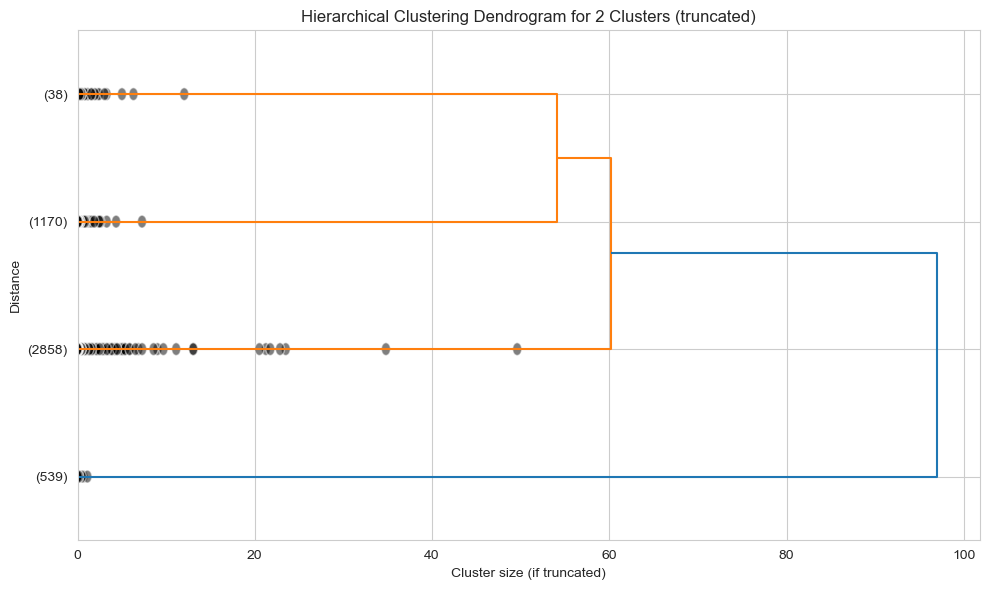

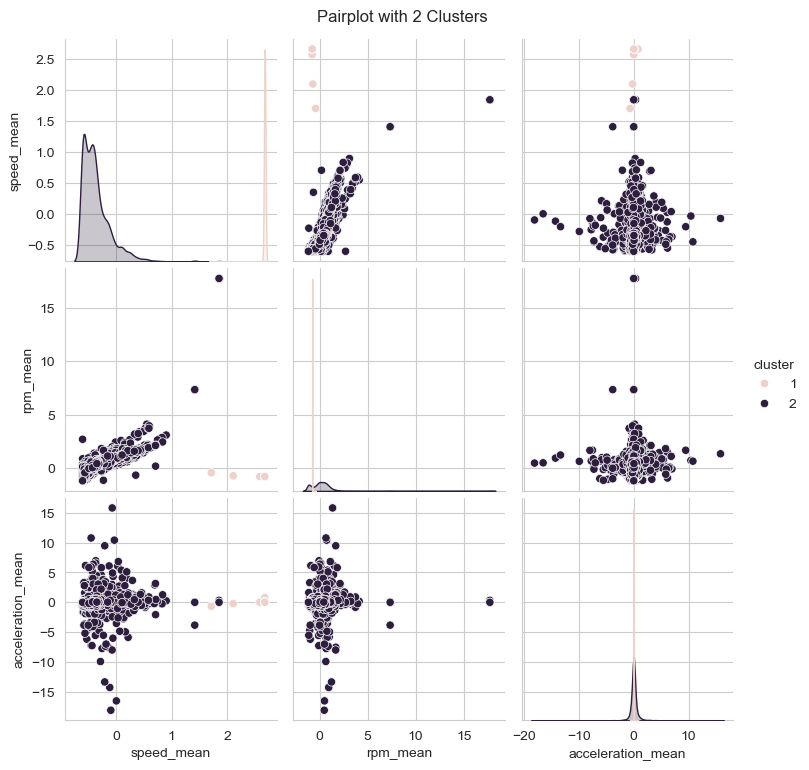

In [ ]:
k=2
dC=80
clustered_data=perform_hierarchical_clustering_analysis(processed_data)

In [ ]:
clustered_data

,deviceID,tripID,speed_mean,speed_max,speed_std,rpm_mean,rpm_max,rpm_std,acceleration_mean,acceleration_max,acceleration_std,kpl_mean,kpl_min,cluster
0,1,0,-0.053781,86.0,31.642210,1.140089,3302.50,910.197835,0.019002,5.000000,1.117795,0.000000,0.000000,2
1,1,1,1.413870,157.0,NaN,7.340078,5508.50,NaN,0.001085,0.000000,NaN,3.540058,3.540058,2
2,1,3,1.848813,191.0,0.000000,17.721802,12228.50,0.000000,0.001863,0.003703,0.000956,1.987960,1.179644,2
3,1,4,1.413870,157.0,0.000000,7.340078,5508.50,0.000000,-0.005062,0.000000,0.003904,3.540058,3.540058,2
4,1,5,1.848813,191.0,0.000000,17.721802,12228.50,0.000000,0.329584,0.208589,0.147495,1.179644,1.179644,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,53,1077,-0.594545,0.0,0.000000,-1.170001,0.00,0.000000,0.001085,0.000000,0.000000,0.000000,0.000000,2
4601,53,1078,-0.380599,51.0,15.373486,0.086620,1744.75,580.059729,-0.128447,4.666667,1.261764,4.092679,0.000000,2
4602,53,1079,-0.481004,39.0,11.397417,-0.024756,1628.00,414.298681,-0.182696,3.500000,0.872782,2.351105,0.000000,2
4603,53,1080,-0.417813,45.0,14.137068,0.047434,1684.50,491.123830,0.061624,4.500000,1.163626,3.377873,0.000000,2


In [ ]:
clustered_data.to_csv('Testing_v2/Clustered_data.csv',index=False)